Model Evaluation for GDP Growth (%) (MSE: 0.20718046639232668, R^2: -0.9026777525825922)
Cross-validated MSE: -37.13661750634927 ± 45.17033292533164
Model Evaluation for Inflation Rate (%) (MSE: 0.2136837585733812, R^2: -6.396745489078575)
Cross-validated MSE: -3.1742801902969884 ± 3.6558055505023637
Model Evaluation for Unemployment Rate (%) (MSE: 0.4219971742111613, R^2: 0.9213018116887599)
Cross-validated MSE: -0.43147037408513816 ± 0.3731586641039324
Model Evaluation for Hospitalisation Rates_smoothed (MSE: 2.805555555555625, R^2: 0.0)
Cross-validated MSE: -0.7521873504245938 ± 1.048586794350692
Model Evaluation for Length of Hospitalisation_smoothed (MSE: 1.0069444444445792, R^2: 0.0)
Cross-validated MSE: -0.2609745119500129 ± 0.3784488438834223
Model Evaluation for Emergencies_smoothed (MSE: 70.1388888888875, R^2: 0.0)
Cross-validated MSE: -18.804683760613983 ± 26.214669858768374
Model Evaluation for Number of Hospitalisations_smoothed (MSE: 16.17361111110998, R^2: 0.0)
Cross-val

03:03:39 - cmdstanpy - INFO - Chain [1] start processing
03:03:40 - cmdstanpy - INFO - Chain [1] done processing
03:03:40 - cmdstanpy - INFO - Chain [1] start processing
03:03:40 - cmdstanpy - INFO - Chain [1] done processing
03:03:40 - cmdstanpy - INFO - Chain [1] start processing
03:03:40 - cmdstanpy - INFO - Chain [1] done processing


Forecasted Values:
    Year  GDP Growth Forecast (%)  Inflation Rate Forecast (%)  \
0  2025                 2.363111                     2.402444   
1  2026                 2.298074                     2.442296   
2  2027                 2.233037                     2.482148   
3  2028                 2.168000                     2.522000   
4  2029                 2.102963                     2.561852   
5  2030                 2.037926                     2.601704   

   Unemployment Rate Forecast (%)  Hospitalisation Rates Forecast  \
0                       11.491778                       13.833333   
1                       11.103185                       14.166667   
2                       10.714593                       14.500000   
3                       10.326000                       14.833333   
4                        9.937407                       15.166667   
5                        9.548815                       15.500000   

   Length of Hospitalisation Forecast  E

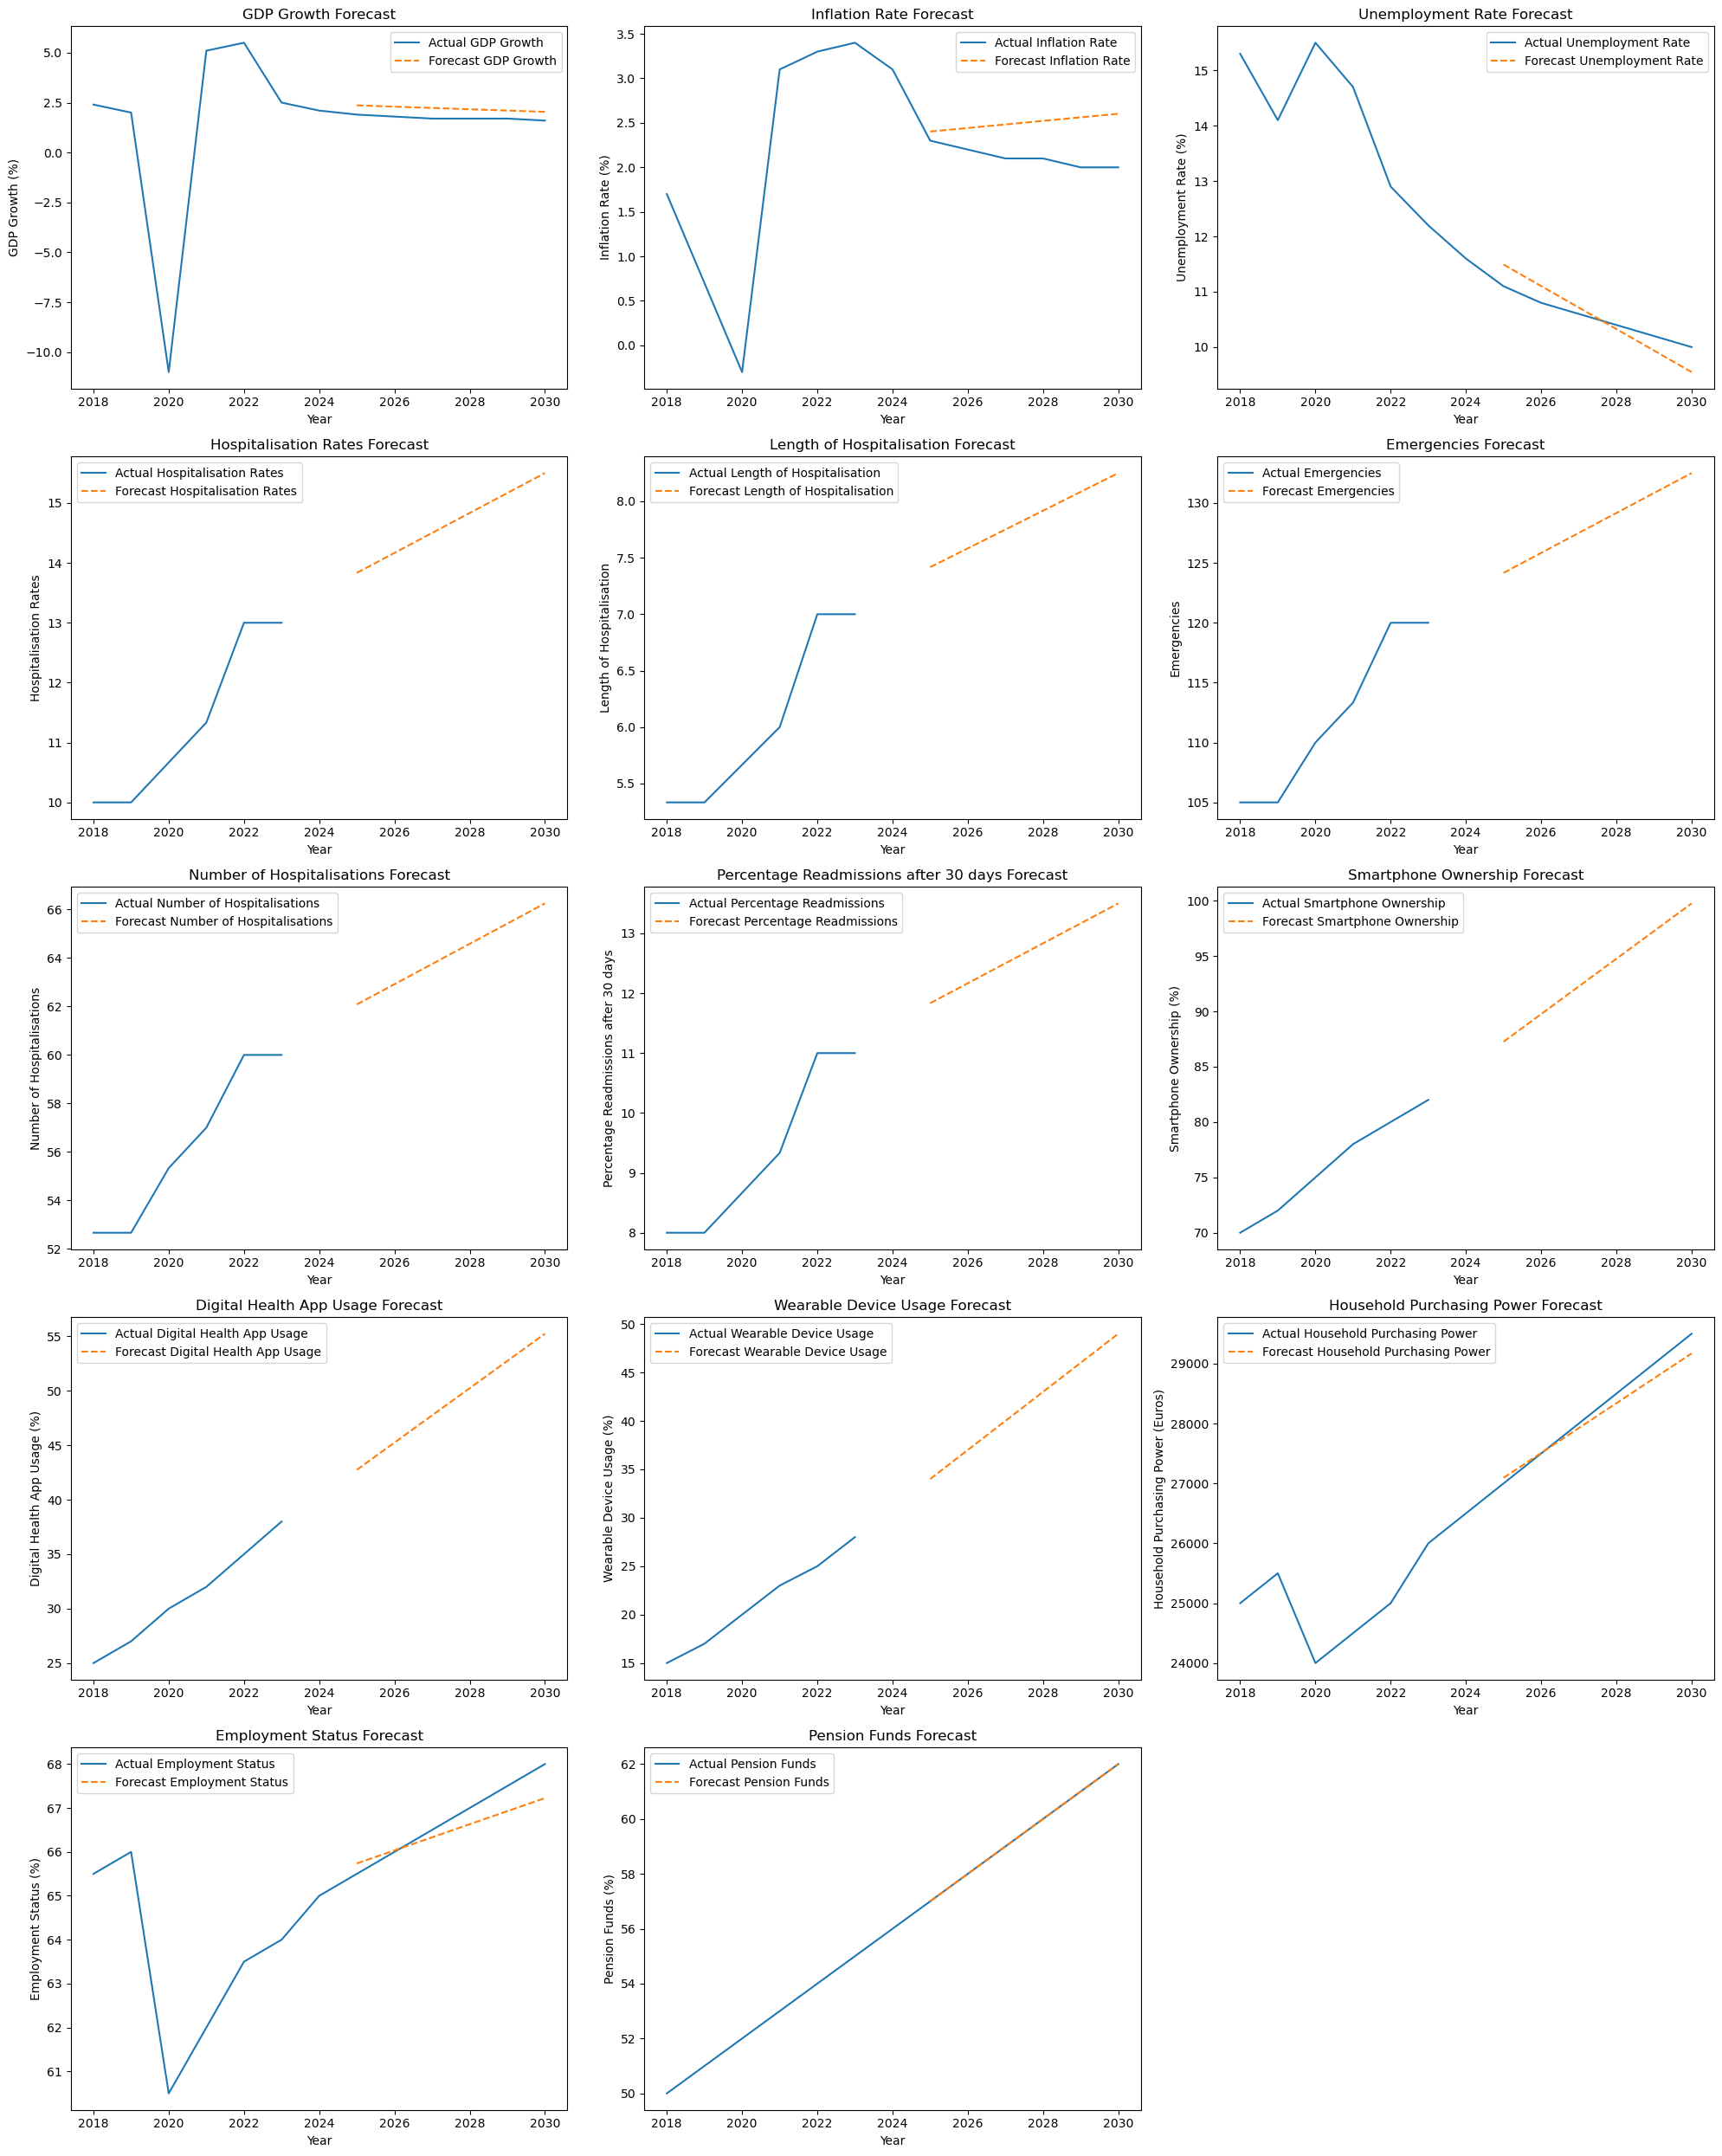

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Load the data from the Excel file
file_path = "C:/Users/pante/OneDrive/CC/processed_data_ rivero.xlsx"  #insert the path that you have the data
sheets = pd.read_excel(file_path, sheet_name=None)

# Extract each sheet into a DataFrame
df_macroeconomic = sheets['Macroeconomic Data']
df_socioeconomic = sheets['Socioeconomic Data']
df_sociodemographic = sheets['Sociodemographic Data']
df_health_wellbeing = sheets['Health Wellbeing Data']
df_digital_tech_adoption = sheets['Digital Tech Adoption']
df_social_lifestyle = sheets['Social Lifestyle Factors']
df_company = sheets['Company Data']

#  useful rounded health data 
new_health_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023],
    'Hospitalisation Rates': [10, 11, 9, 12, 13, 14],
    'Length of Hospitalisation': [5, 6, 5, 6, 7, 8],
    'Emergencies': [100, 110, 105, 115, 120, 125],
    'Number of Hospitalisations': [50, 55, 53, 58, 60, 62],
    'Percentage Readmissions after 30 days': [8, 9, 7, 10, 11, 12]
}

df_new_health = pd.DataFrame(new_health_data)


# Data Cleaning and Preprocessing
def preprocess(df):
    df = df.dropna().astype(float)
    return df


df_macroeconomic = preprocess(df_macroeconomic)
df_socioeconomic = preprocess(df_socioeconomic)
df_sociodemographic = preprocess(df_sociodemographic)
df_health_wellbeing = preprocess(df_health_wellbeing)
df_digital_tech_adoption = preprocess(df_digital_tech_adoption)
df_social_lifestyle = preprocess(df_social_lifestyle)
df_new_health = preprocess(df_new_health)


# Apply smoothing
def apply_smoothing(df, column, window=3):
    df[column + '_smoothed'] = df[column].rolling(window=window, center=True).mean().fillna(method='bfill').fillna(
        method='ffill')
    return df


# Smooth the health-related columns to mitigate COVID-19 impact
df_new_health = apply_smoothing(df_new_health, 'Hospitalisation Rates')
df_new_health = apply_smoothing(df_new_health, 'Length of Hospitalisation')
df_new_health = apply_smoothing(df_new_health, 'Emergencies')
df_new_health = apply_smoothing(df_new_health, 'Number of Hospitalisations')
df_new_health = apply_smoothing(df_new_health, 'Percentage Readmissions after 30 days')

# Add a  variable for COVID-19 impact
df_macroeconomic['COVID'] = df_macroeconomic['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)
df_new_health['COVID'] = df_new_health['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)
df_digital_tech_adoption['COVID'] = df_digital_tech_adoption['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)
df_socioeconomic['COVID'] = df_socioeconomic['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)

#  archetype segmentation and urban/rural addition
df_sociodemographic['Archetype'] = ['Healthy'] * 2 + ['Chronic'] * 2 + ['Impaired'] * 2
df_sociodemographic['Urban_Rural'] = ['Urban'] * 3 + ['Rural'] * 3



# Helper function to create and evaluate linear regression models
def create_linear_regression_model(df, feature_cols, target_col, forecast_years):
    # Prepare the data
    X = pd.get_dummies(df[feature_cols])
    y = df[target_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model Evaluation for {target_col} (MSE: {mse}, R^2: {r2})")

    # Cross-validate the model
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validated MSE: {np.mean(scores)} ± {np.std(scores)}")

    # Forecast future values
    future_years_df = pd.DataFrame({'Year': forecast_years, 'COVID': [0] * len(forecast_years)})
    future_forecast = model.predict(pd.get_dummies(future_years_df[feature_cols]))

    return model, future_forecast

# Advanced Time Series Models (ARIMA and Prophet)
def create_arima_model(df, column, order=(1, 1, 1)):
    try:
        model = ARIMA(df[column], order=order)
        results = model.fit()
        forecast = results.get_forecast(steps=len(forecast_years))
        forecast_index = pd.date_range(start=df['Year'].max() + 1, periods=len(forecast_years), freq='Y')
        forecast_df = forecast.conf_int(alpha=0.05)
        forecast_df['Forecast'] = forecast.predicted_mean
        forecast_df.index = forecast_index
        return forecast_df
    except Exception as e:
        print(f"Error creating ARIMA model for {column}: {e}")
        return pd.DataFrame()

def create_prophet_model(df, column, forecast_years):
    df_prophet = df[['Year', column]].rename(columns={'Year': 'ds', column: 'y'})
    model = Prophet()
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=len(forecast_years), freq='Y')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


# Forecast years
forecast_years = [2025, 2026, 2027, 2028, 2029, 2030]

# Create models and forecast future values for key indicators
gdp_model, gdp_forecast = create_linear_regression_model(df_macroeconomic, ['Year', 'COVID'], 'GDP Growth (%)',
                                                         forecast_years)
inflation_model, inflation_forecast = create_linear_regression_model(df_macroeconomic, ['Year', 'COVID'],
                                                                     'Inflation Rate (%)', forecast_years)
unemployment_model, unemployment_forecast = create_linear_regression_model(df_macroeconomic, ['Year', 'COVID'],
                                                                           'Unemployment Rate (%)', forecast_years)

# Forecast health-related services using new health data
hospitalisation_model, hospitalisation_forecast = create_linear_regression_model(df_new_health, ['Year', 'COVID'],
                                                                                 'Hospitalisation Rates_smoothed',
                                                                                 forecast_years)
length_hospitalisation_model, length_hospitalisation_forecast = create_linear_regression_model(df_new_health,
                                                                                               ['Year', 'COVID'],
                                                                                               'Length of Hospitalisation_smoothed',
                                                                                               forecast_years)
emergencies_model, emergencies_forecast = create_linear_regression_model(df_new_health, ['Year', 'COVID'],
                                                                         'Emergencies_smoothed', forecast_years)
number_hospitalisations_model, number_hospitalisations_forecast = create_linear_regression_model(df_new_health,
                                                                                                 ['Year', 'COVID'],
                                                                                                 'Number of Hospitalisations_smoothed',
                                                                                                 forecast_years)
readmissions_model, readmissions_forecast = create_linear_regression_model(df_new_health, ['Year', 'COVID'],
                                                                           'Percentage Readmissions after 30 days_smoothed',
                                                                           forecast_years)

# Forecast digital technology adoption
smartphone_model, smartphone_forecast = create_linear_regression_model(df_digital_tech_adoption, ['Year', 'COVID'],
                                                                       'Smartphone Ownership (%)', forecast_years)
health_app_model, health_app_forecast = create_linear_regression_model(df_digital_tech_adoption, ['Year', 'COVID'],
                                                                       'Digital Health App Usage (%)', forecast_years)
wearable_device_model, wearable_device_forecast = create_linear_regression_model(df_digital_tech_adoption,
                                                                                 ['Year', 'COVID'],
                                                                                 'Wearable Device Usage (%)',
                                                                                 forecast_years)
# Forecasts for Sociodemographic Data
population_model, population_forecast = create_linear_regression_model(df_sociodemographic, ['Year'], 'Population', forecast_years)
median_age_model, median_age_forecast = create_linear_regression_model(df_sociodemographic, ['Year'], 'Median Age', forecast_years)
urban_population_model, urban_population_forecast = create_linear_regression_model(df_sociodemographic, ['Year'], 'Urban Population (%)', forecast_years)

# Forecast socioeconomic factors 
purchasing_power_model, purchasing_power_forecast = create_linear_regression_model(df_socioeconomic, ['Year', 'COVID'], 'Household Purchasing Power (Euros)', forecast_years)
employment_status_model, employment_status_forecast = create_linear_regression_model(df_socioeconomic, ['Year', 'COVID'], 'Employment Status (%)', forecast_years)
pension_funds_model, pension_funds_forecast = create_linear_regression_model(df_socioeconomic, ['Year', 'COVID'], 'Pension Funds (%)', forecast_years)



# Create ARIMA and Prophet models for better forecasting
arima_gdp_forecast = create_arima_model(df_macroeconomic, 'GDP Growth (%)')
arima_inflation_forecast = create_arima_model(df_macroeconomic, 'Inflation Rate (%)')
arima_unemployment_forecast = create_arima_model(df_macroeconomic, 'Unemployment Rate (%)')

prophet_gdp_forecast = create_prophet_model(df_macroeconomic, 'GDP Growth (%)', forecast_years)
prophet_inflation_forecast = create_prophet_model(df_macroeconomic, 'Inflation Rate (%)', forecast_years)
prophet_unemployment_forecast = create_prophet_model(df_macroeconomic, 'Unemployment Rate (%)', forecast_years)


# Display the forecasts
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'GDP Growth Forecast (%)': gdp_forecast,
    'Inflation Rate Forecast (%)': inflation_forecast,
    'Unemployment Rate Forecast (%)': unemployment_forecast,
    'Hospitalisation Rates Forecast': hospitalisation_forecast,
    'Length of Hospitalisation Forecast': length_hospitalisation_forecast,
    'Emergencies Forecast': emergencies_forecast,
    'Number of Hospitalisations Forecast': number_hospitalisations_forecast,
    'Percentage Readmissions after 30 days Forecast': readmissions_forecast,
    'Smartphone Ownership Forecast (%)': smartphone_forecast,
    'Digital Health App Usage Forecast (%)': health_app_forecast,
    'Wearable Device Usage Forecast (%)': wearable_device_forecast,
    'Household Purchasing Power Forecast (Euros)': purchasing_power_forecast,
    'Employment Status Forecast (%)': employment_status_forecast,
    'Pension Funds Forecast (%)': pension_funds_forecast,
    
})

print("Forecasted Values:\n", forecast_df)
desktop_path = "C:/Users/pante/OneDrive/Έγγραφα"
forecast_df.to_csv(f"{desktop_path}/forecast_data.csv", index=False)

print(f"Forecast data has been exported to {desktop_path}/forecast_data.csv")

# Visualize the forecasts
plt.figure(figsize=(20, 25))

plt.subplot(5, 3, 1)
plt.plot(df_macroeconomic['Year'], df_macroeconomic['GDP Growth (%)'], label='Actual GDP Growth')
plt.plot(forecast_df['Year'], forecast_df['GDP Growth Forecast (%)'], label='Forecast GDP Growth', linestyle='--')
plt.title('GDP Growth Forecast')
plt.xlabel('Year')
plt.ylabel('GDP Growth (%)')
plt.legend()

plt.subplot(5, 3, 2)
plt.plot(df_macroeconomic['Year'], df_macroeconomic['Inflation Rate (%)'], label='Actual Inflation Rate')
plt.plot(forecast_df['Year'], forecast_df['Inflation Rate Forecast (%)'], label='Forecast Inflation Rate', linestyle='--')
plt.title('Inflation Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()

plt.subplot(5, 3, 3)
plt.plot(df_macroeconomic['Year'], df_macroeconomic['Unemployment Rate (%)'], label='Actual Unemployment Rate')
plt.plot(forecast_df['Year'], forecast_df['Unemployment Rate Forecast (%)'], label='Forecast Unemployment Rate', linestyle='--')
plt.title('Unemployment Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend()

plt.subplot(5, 3, 4)
plt.plot(df_new_health['Year'], df_new_health['Hospitalisation Rates_smoothed'], label='Actual Hospitalisation Rates')
plt.plot(forecast_df['Year'], forecast_df['Hospitalisation Rates Forecast'], label='Forecast Hospitalisation Rates', linestyle='--')
plt.title('Hospitalisation Rates Forecast')
plt.xlabel('Year')
plt.ylabel('Hospitalisation Rates')
plt.legend()

plt.subplot(5, 3, 5)
plt.plot(df_new_health['Year'], df_new_health['Length of Hospitalisation_smoothed'], label='Actual Length of Hospitalisation')
plt.plot(forecast_df['Year'], forecast_df['Length of Hospitalisation Forecast'], label='Forecast Length of Hospitalisation', linestyle='--')
plt.title('Length of Hospitalisation Forecast')
plt.xlabel('Year')
plt.ylabel('Length of Hospitalisation')
plt.legend()



plt.subplot(5, 3, 6)
plt.plot(df_new_health['Year'], df_new_health['Emergencies_smoothed'], label='Actual Emergencies')
plt.plot(forecast_df['Year'], forecast_df['Emergencies Forecast'], label='Forecast Emergencies', linestyle='--')
plt.title('Emergencies Forecast')
plt.xlabel('Year')
plt.ylabel('Emergencies')
plt.legend()

plt.subplot(5, 3, 7)
plt.plot(df_new_health['Year'], df_new_health['Number of Hospitalisations_smoothed'], label='Actual Number of Hospitalisations')
plt.plot(forecast_df['Year'], forecast_df['Number of Hospitalisations Forecast'], label='Forecast Number of Hospitalisations', linestyle='--')
plt.title('Number of Hospitalisations Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Hospitalisations')
plt.legend()

plt.subplot(5, 3, 8)
plt.plot(df_new_health['Year'], df_new_health['Percentage Readmissions after 30 days_smoothed'], label='Actual Percentage Readmissions')
plt.plot(forecast_df['Year'], forecast_df['Percentage Readmissions after 30 days Forecast'], label='Forecast Percentage Readmissions', linestyle='--')
plt.title('Percentage Readmissions after 30 days Forecast')
plt.xlabel('Year')
plt.ylabel('Percentage Readmissions after 30 days')
plt.legend()

plt.subplot(5, 3, 9)
plt.plot(df_digital_tech_adoption['Year'], df_digital_tech_adoption['Smartphone Ownership (%)'], label='Actual Smartphone Ownership')
plt.plot(forecast_df['Year'], forecast_df['Smartphone Ownership Forecast (%)'], label='Forecast Smartphone Ownership', linestyle='--')
plt.title('Smartphone Ownership Forecast')
plt.xlabel('Year')
plt.ylabel('Smartphone Ownership (%)')
plt.legend()

plt.subplot(5, 3, 10)
plt.plot(df_digital_tech_adoption['Year'], df_digital_tech_adoption['Digital Health App Usage (%)'], label='Actual Digital Health App Usage')
plt.plot(forecast_df['Year'], forecast_df['Digital Health App Usage Forecast (%)'], label='Forecast Digital Health App Usage', linestyle='--')
plt.title('Digital Health App Usage Forecast')
plt.xlabel('Year')
plt.ylabel('Digital Health App Usage (%)')
plt.legend()

plt.subplot(5, 3, 11)
plt.plot(df_digital_tech_adoption['Year'], df_digital_tech_adoption['Wearable Device Usage (%)'], label='Actual Wearable Device Usage')
plt.plot(forecast_df['Year'], forecast_df['Wearable Device Usage Forecast (%)'], label='Forecast Wearable Device Usage', linestyle='--')
plt.title('Wearable Device Usage Forecast')
plt.xlabel('Year')
plt.ylabel('Wearable Device Usage (%)')
plt.legend()

plt.subplot(5, 3, 12)
plt.plot(df_socioeconomic['Year'], df_socioeconomic['Household Purchasing Power (Euros)'], label='Actual Household Purchasing Power')
plt.plot(forecast_df['Year'], forecast_df['Household Purchasing Power Forecast (Euros)'], label='Forecast Household Purchasing Power', linestyle='--')
plt.title('Household Purchasing Power Forecast')
plt.xlabel('Year')
plt.ylabel('Household Purchasing Power (Euros)')
plt.legend()

plt.subplot(5, 3, 13)
plt.plot(df_socioeconomic['Year'], df_socioeconomic['Employment Status (%)'], label='Actual Employment Status')
plt.plot(forecast_df['Year'], forecast_df['Employment Status Forecast (%)'], label='Forecast Employment Status', linestyle='--')
plt.title('Employment Status Forecast')
plt.xlabel('Year')
plt.ylabel('Employment Status (%)')
plt.legend()

plt.subplot(5, 3, 14)
plt.plot(df_socioeconomic['Year'], df_socioeconomic['Pension Funds (%)'], label='Actual Pension Funds')
plt.plot(forecast_df['Year'], forecast_df['Pension Funds Forecast (%)'], label='Forecast Pension Funds', linestyle='--')
plt.title('Pension Funds Forecast')
plt.xlabel('Year')
plt.ylabel('Pension Funds (%)')
plt.legend()



plt.tight_layout()
plt.show()











In [ ]:
"C:/Users/pante/OneDrive/CC/processed_data_ rivero.xlsx"